<html><h1><center style="color:blue">Applying LSTM Models on Raw Data</center></h1></html>

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2
from keras import models    


In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to print the confusion matrix

def confusion_matrix(Y_true, Y_pred):
    
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    
    print(Y_true)
    print(Y_pred)
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

    
    

<html><h1><p style="color:red">Loading Data / Making Data </p></h1></html>

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [5]:
# function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [9]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32
pv = 0.25

In [10]:
#function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [11]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [12]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


<html><h1><p style="color:red">1. Defining the Architecture of 1-Layer of LSTM </p></h1></html>

In [13]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(pv))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,702
Trainable params: 5,638
Non-trainable params: 64
_________________________________________________________________


In [14]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 19s 34ms/step - loss: 0.8532 - accuracy: 0.6507 - val_loss: 1.6680 - val_accuracy: 0.4062
Epoch 2/30
460/460 [==============================] - 15s 32ms/step - loss: 0.4084 - accuracy: 0.8444 - val_loss: 0.7941 - val_accuracy: 0.7716
Epoch 3/30
460/460 [==============================] - 15s 32ms/step - loss: 0.2619 - accuracy: 0.9105 - val_loss: 0.6372 - val_accuracy: 0.8470
Epoch 4/30
460/460 [==============================] - 15s 33ms/step - loss: 0.2149 - accuracy: 0.9227 - val_loss: 0.4043 - val_accuracy: 0.8962
Epoch 5/30
460/460 [==============================] - 14s 31ms/step - loss: 0.1988 - accuracy: 0.9308 - val_loss: 0.3896 - val_accuracy: 0.8996
Epoch 6/30
460/460 [==============================] - 14s 31ms/step - loss: 0.1790 - accuracy: 0.9359 - val_loss: 0.3668 - val_accuracy: 0.9053
Epoch 7/30
460/460 [==============================] - 14s 31ms/step - loss: 0.1669 - accuracy: 0.9377 - val_loss: 0.2703 - val_accuracy:

In [16]:
model.save('lstm_1_layer_model.h5')

In [17]:
# load model from single file
from keras.models import load_model

model1 = load_model('lstm_1_layer_model.h5')

In [18]:
# Confusion Matrix
confusion_matrix(Y_test, model1.predict(X_test))

93/93 [==============================] - 1s 11ms/step
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object


Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,410,75,0,0,6
STANDING,0,105,427,0,0,0
WALKING,0,0,0,470,6,20
WALKING_DOWNSTAIRS,0,0,0,2,413,5
WALKING_UPSTAIRS,0,0,0,35,12,424


In [19]:
score = model1.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 11ms/step - loss: 0.3847 - accuracy: 0.9097

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.3847391605377197, 0.9097387194633484]


In [20]:

yhat = model1.predict(X_test)

print(X_test)
print(Y_test)

93/93 [==============================] - 1s 10ms/step
[[[ 1.165315e-02 -2.939904e-02  1.068262e-01 ...  1.041216e+00
   -2.697959e-01  2.377977e-02]
  [ 1.310909e-02 -3.972867e-02  1.524549e-01 ...  1.041803e+00
   -2.800250e-01  7.629271e-02]
  [ 1.126885e-02 -5.240586e-02  2.168462e-01 ...  1.039086e+00
   -2.926631e-01  1.474754e-01]
  ...
  [ 1.291511e-03  1.173502e-02  3.665587e-03 ...  9.930164e-01
   -2.599865e-01  1.443951e-01]
  [ 1.469997e-03  9.517414e-03  4.041945e-03 ...  9.932414e-01
   -2.620643e-01  1.447033e-01]
  [ 2.573841e-03  7.305069e-03  4.888436e-03 ...  9.943906e-01
   -2.641348e-01  1.454939e-01]]

 [[ 9.279629e-03  6.650520e-03 -2.631933e-02 ...  9.991921e-01
   -2.649349e-01  1.256164e-01]
  [ 4.929711e-03  1.864973e-02 -2.688753e-02 ...  9.946787e-01
   -2.532142e-01  1.256249e-01]
  [ 3.953596e-03  1.553950e-02 -3.663861e-02 ...  9.935518e-01
   -2.565887e-01  1.163814e-01]
  ...
  [ 7.787600e-03  4.730625e-03  1.412899e-02 ...  1.001861e+00
   -2.619359e-

<html><h3><p style="color:#008080">With a simple 1 layer architecture we got 92.64% accuracy and a loss of 0.277</p></h4></html>

<html><h1><p style="color:red">2. Defining the Architecture of 2-Layer of LSTM with more hyperparameter tunning </p></h1></html>

### 2.1 First Model for 2-Layer of LSTM with more hyperparameter tunning

In [21]:
# Initializing parameters
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [22]:
# Model execution
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(LSTM(64))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                      

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 52s 106ms/step - loss: 2.3312 - accuracy: 0.8183 - val_loss: 1.7381 - val_accuracy: 0.8225
Epoch 2/30
460/460 [==============================] - 48s 105ms/step - loss: 0.9723 - accuracy: 0.9253 - val_loss: 0.7032 - val_accuracy: 0.8846
Epoch 3/30
460/460 [==============================] - 48s 103ms/step - loss: 0.3583 - accuracy: 0.9286 - val_loss: 0.3500 - val_accuracy: 0.8527
Epoch 4/30
460/460 [==============================] - 48s 103ms/step - loss: 0.1842 - accuracy: 0.9338 - val_loss: 0.2639 - val_accuracy: 0.9077
Epoch 5/30
460/460 [==============================] - 48s 104ms/step - loss: 0.1564 - accuracy: 0.9410 - val_loss: 0.3084 - val_accuracy: 0.8955
Epoch 6/30
460/460 [==============================] - 48s 104ms/step - loss: 0.1763 - accuracy: 0.9329 - val_loss: 0.2939 - val_accuracy: 0.9009
Epoch 7/30
460/460 [==============================] - 48s 105ms/step - loss: 0.1500 - accuracy: 0.9448 - val_loss: 0.2436 - val_ac

In [25]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 5s 44ms/step
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object


Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,325,212,0,0,0,0
SITTING,8,325,157,0,0,1
STANDING,0,46,486,0,0,0
WALKING,0,0,0,469,25,2
WALKING_DOWNSTAIRS,0,0,4,7,406,3
WALKING_UPSTAIRS,0,0,0,15,35,421


In [26]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 4s 45ms/step - loss: 0.7546 - accuracy: 0.8252

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.7546157836914062, 0.8252460360527039]


### 2.2 Second Model for 2-Layer of LSTM with more hyperparameter tunning

In [27]:
# Model execution
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(48))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_2 (Batc  (None, 128, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 48)                21696     
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 294       
                                      

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 39s 78ms/step - loss: 1.6749 - accuracy: 0.7085 - val_loss: 1.8827 - val_accuracy: 0.6373
Epoch 2/30
460/460 [==============================] - 35s 76ms/step - loss: 0.7199 - accuracy: 0.8898 - val_loss: 0.6894 - val_accuracy: 0.7961
Epoch 3/30
460/460 [==============================] - 34s 75ms/step - loss: 0.3785 - accuracy: 0.9086 - val_loss: 0.5497 - val_accuracy: 0.8110
Epoch 4/30
460/460 [==============================] - 36s 79ms/step - loss: 0.2299 - accuracy: 0.9240 - val_loss: 0.3792 - val_accuracy: 0.8663
Epoch 5/30
460/460 [==============================] - 36s 78ms/step - loss: 0.2126 - accuracy: 0.9232 - val_loss: 0.2708 - val_accuracy: 0.9087
Epoch 6/30
460/460 [==============================] - 36s 78ms/step - loss: 0.1702 - accuracy: 0.9366 - val_loss: 0.2493 - val_accuracy: 0.9182
Epoch 7/30
460/460 [==============================] - 36s 77ms/step - loss: 0.1570 - accuracy: 0.9423 - val_loss: 0.2452 - val_accuracy:

In [30]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 3s 28ms/step
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object


Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,6,399,85,0,0,1
STANDING,0,90,441,0,0,1
WALKING,0,0,0,464,22,10
WALKING_DOWNSTAIRS,0,0,0,2,418,0
WALKING_UPSTAIRS,0,0,0,0,29,442


In [31]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 3s 28ms/step - loss: 0.3319 - accuracy: 0.9165

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.33185917139053345, 0.9165253043174744]


In [32]:
from mlxtend.plotting import plot_confusion_matrix

93/93 [==============================] - 3s 29ms/step
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object
0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
2942    WALKING_UPSTAIRS
2943    WALKING_UPSTAIRS
2944    WALKING_UPSTAIRS
2945    WALKING_UPSTAIRS
2946    WALKING_UPSTAIRS
Length: 2947, dtype: object


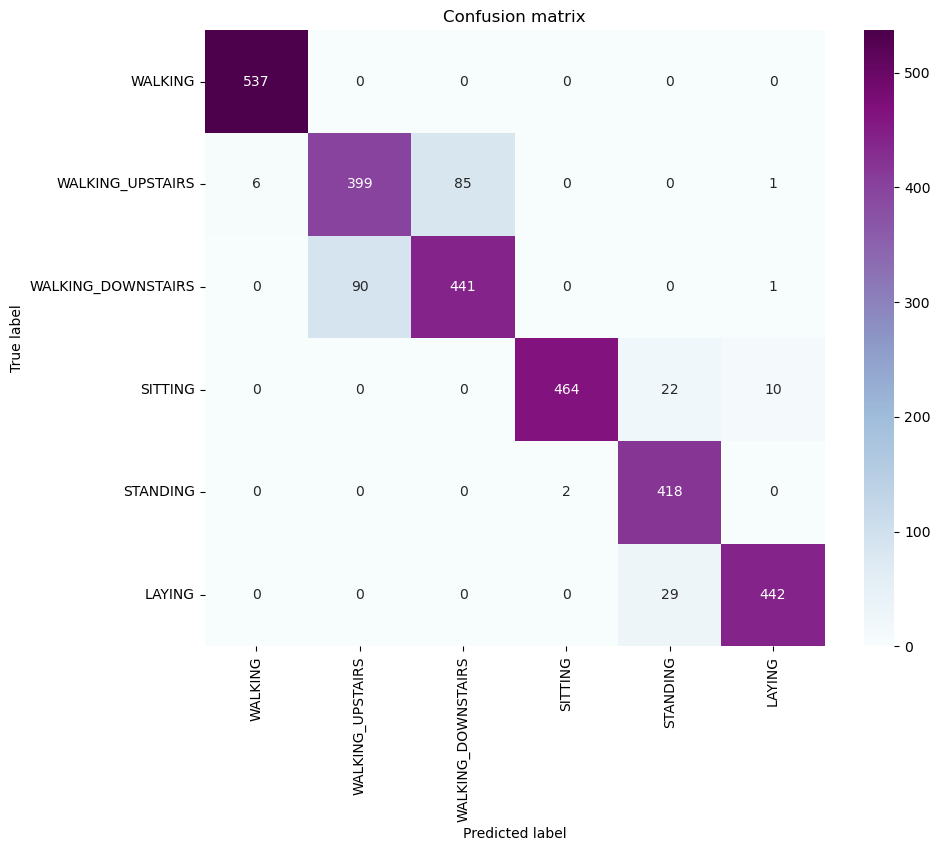

In [33]:
result = confusion_matrix(Y_test, model.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(result, 
                xticklabels= list(ACTIVITIES.values()), 
                yticklabels=list(ACTIVITIES.values()), 
                annot=True, fmt="d", cmap="BuPu");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()  

In [34]:
model.save('lstm_2_2layer_model.h5')

In [35]:
model2 = load_model('lstm_2_2layer_model.h5')

In [36]:
score = model2.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 3s 25ms/step - loss: 0.3319 - accuracy: 0.9165

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.33185917139053345, 0.9165253043174744]
